importation de packages

In [2]:
import pandas as pd
import numpy as np
import openpyxl as xl
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller
from tabulate import tabulate
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
import statsmodels.api as sm

importation de donnees

In [4]:
df=pd.read_excel("FS_DATA_DAS.xlsx")
df

,Date,Recettes,Change,IPC
0,1998-10-01,4.511900e+08,16.3043,7.497835
1,1998-11-01,3.793800e+08,16.5948,8.022774
2,1998-12-01,3.967000e+08,16.5046,7.447713
3,1999-01-01,4.376500e+08,16.7778,7.375875
4,1999-02-01,4.147200e+08,16.8943,7.932369
...,...,...,...,...
307,2024-05-01,4.974492e+09,132.5137,28.300000
308,2024-06-01,6.102811e+09,132.2823,28.900000
309,2024-07-01,4.995281e+09,131.7522,30.000000
310,2024-08-01,4.843745e+09,131.5083,29.300000


exploration de donnees

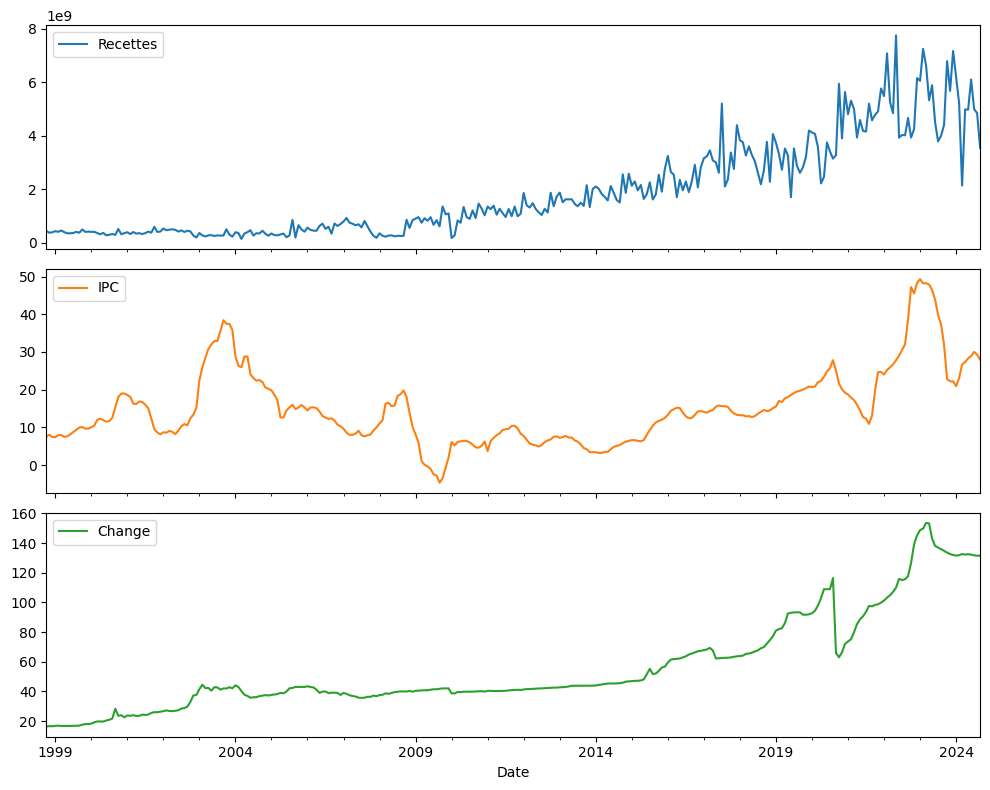

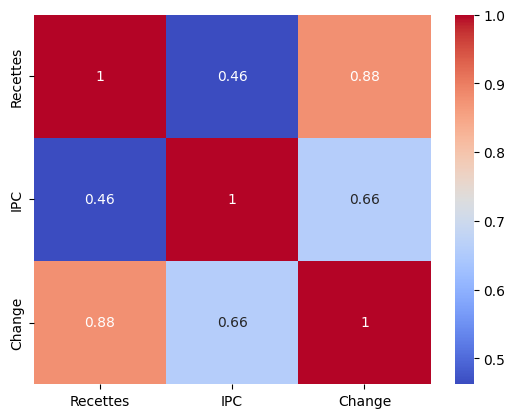

In [5]:
# Courbes d’évolution
df.set_index('Date')[['Recettes', 'IPC', 'Change']].plot(subplots=True, figsize=(10, 8))
plt.tight_layout()
plt.show()

# Corrélations
sns.heatmap(df[['Recettes', 'IPC', 'Change']].corr(), annot=True, cmap='coolwarm')
plt.show()

Test de Stationnarité

In [6]:
def adf_test(series, name):
    result = adfuller(series.dropna())
    print(f"ADF Test for {name}:")
    print(f"  ADF Statistic: {result[0]:.4f}")
    print(f"  p-value: {result[1]:.4f}")
    print("  Stationary" if result[1] < 0.05 else "  Non-stationary")
    print("-" * 40)

for col in ['Recettes', 'IPC', 'Change']:
    adf_test(df[col], col)

ADF Test for Recettes:
  ADF Statistic: 0.5446
  p-value: 0.9862
  Non-stationary
----------------------------------------
ADF Test for IPC:
  ADF Statistic: -1.6526
  p-value: 0.4557
  Non-stationary
----------------------------------------
ADF Test for Change:
  ADF Statistic: 0.0994
  p-value: 0.9660
  Non-stationary
----------------------------------------


Test de stationnarite des residus en niveau

In [7]:
# Étape 1 : Régression sur les niveaux
X = df[['IPC', 'Change']]
X = sm.add_constant(X)
y = df['Recettes']
model = sm.OLS(y, X).fit()

# Étape 2 : Tester la stationnarité des résidus
residuals = model.resid
result = adfuller(residuals)
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("  Stationary" if result[1] < 0.05 else "  Non-stationary")

ADF Statistic: -2.9434972966452113
p-value: 0.040518643984843866
  Stationary


ACF et PACF des residus

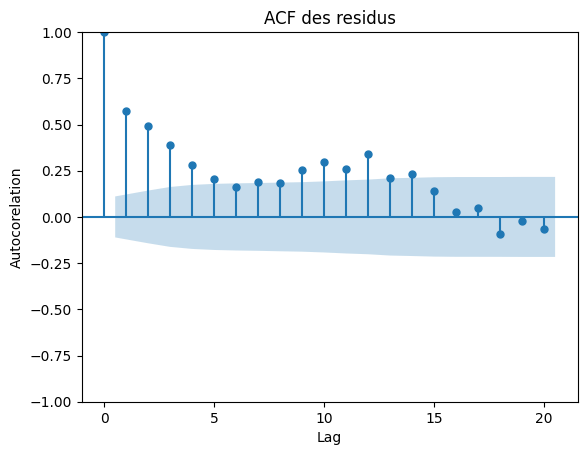

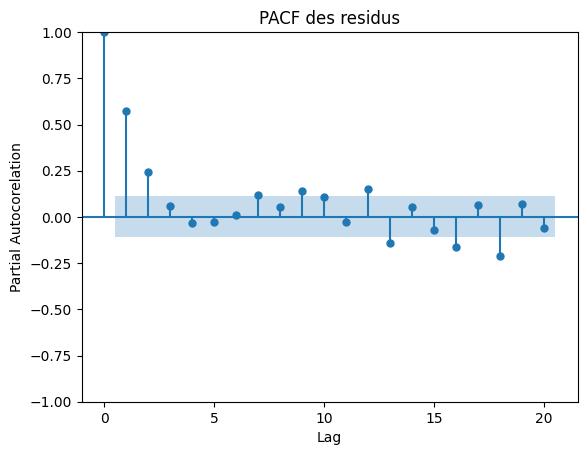

In [8]:
#tracer la fonction ACF des residus
plot_acf(residuals,lags=20)
plt.xlabel('Lag')
plt.ylabel('Autocorelation')
plt.title('ACF des residus')
plt.show()

#tracer la fonction PACF des residus
plot_pacf(residuals,lags=20)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorelation')
plt.title('PACF des residus')
plt.show()

Estimation du modele

In [9]:
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               Recettes   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     599.0
Date:                Thu, 26 Jun 2025   Prob (F-statistic):          4.83e-107
Time:                        18:50:30   Log-Likelihood:                -6837.1
No. Observations:                 312   AIC:                         1.368e+04
Df Residuals:                     309   BIC:                         1.369e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -6.41e+08   9.32e+07     -6.876      0.0

visualisation de resultat du modele par rapport au donnees reelles

In [ ]:
# Indexation temporelle 
df.index = pd.date_range(start='1998-10-01', periods=len(df), freq='M')

# 12 derniers mois = test
train_df = df.iloc[:-12]
test_df = df.iloc[-12:]

# X et y d'entraînement
X_train = sm.add_constant(train_df[['IPC', 'Change']])
y_train = train_df['Recettes']

# Estimation sur train uniquement
model_train = sm.OLS(y_train, X_train).fit()

# X de test
X_test = sm.add_constant(test_df[['IPC', 'Change']])


In [16]:
# Prédiction sur train
train_pred = model_train.predict(X_train)

# Prédiction sur test
test_pred = model_train.predict(X_test)

# Concaténer les prédictions
all_pred = pd.concat([train_pred, test_pred])


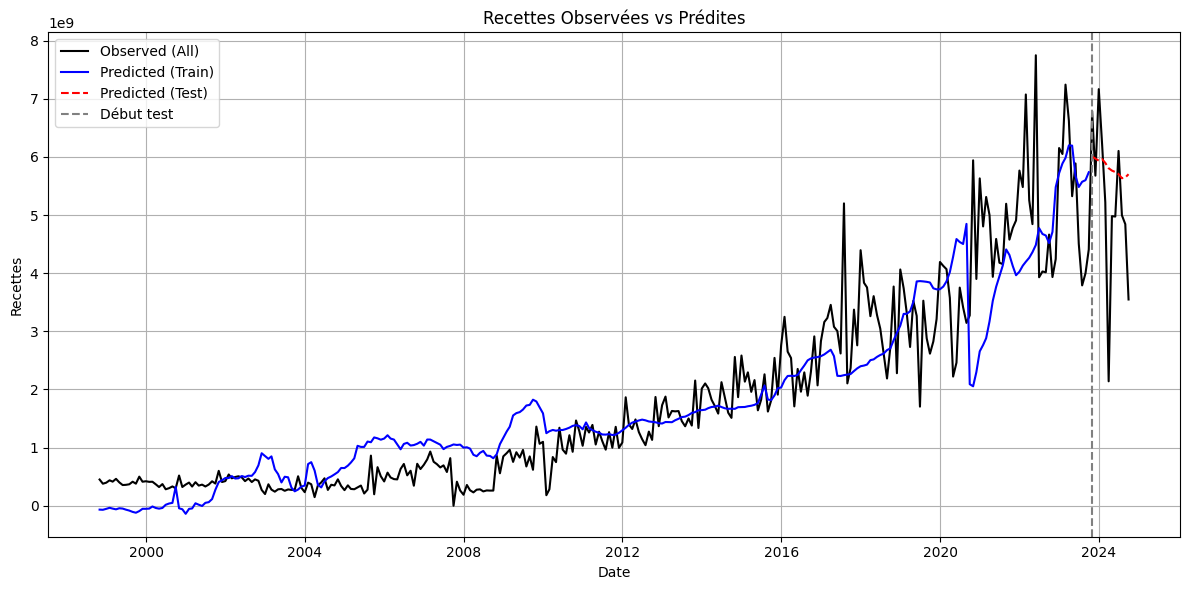

In [17]:
plt.figure(figsize=(12,6))

# Observé
plt.plot(df['Recettes'], label='Observed (All)', color='black')
plt.plot(train_pred, label='Predicted (Train)', color='blue')
plt.plot(test_pred, label='Predicted (Test)', color='red', linestyle='--')

# Zones
plt.axvline(df.index[-12], color='gray', linestyle='--', label='Début test')

plt.title('Recettes Observées vs Prédites')
plt.xlabel('Date')
plt.ylabel('Recettes')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
# Créer les dummies mensuelles
df['Mois'] = df.index.month
dummies = pd.get_dummies(df['Mois'], prefix='Mois', drop_first=True)

# Créer le DataFrame complet
df_model = pd.concat([df[['Recettes', 'IPC', 'Change']], dummies], axis=1).dropna()

# Définir X et y
X = df_model.drop('Recettes', axis=1)
y = df_model['Recettes']

# ✅ Forcer en float
X = X.astype(float)
y = y.astype(float)

# Ajouter constante et estimer
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               Recettes   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     100.0
Date:                Wed, 25 Jun 2025   Prob (F-statistic):          2.30e-100
Time:                        18:04:49   Log-Likelihood:                -6822.6
No. Observations:                 312   AIC:                         1.367e+04
Df Residuals:                     298   BIC:                         1.373e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.793e+08   1.71e+08     -2.215      0.0